In [1]:
import random

import flax
import flax.linen as nn
import jax
import jax.numpy as jnp
import numpy as np
import optax
from flax.training.train_state import TrainState
from stable_baselines3.common.buffers import ReplayBuffer

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import trange

from rl_env.myenv_2d import MyEnv2D
from base_rl_mcmc.toolbox import flat

import toml
from typing import Sequence
from types import SimpleNamespace

import os
import json
import pandas as pd
import bridgestan as bs
from posteriordb import PosteriorDatabase

%matplotlib inline
# %config InlineBackend.figure_format = 'svg'

config = toml.load("./base_rl_mcmc/config/config_ddpg.toml")
args = SimpleNamespace(**config)

# seeding
random.seed(args.seed)
np.random.seed(args.seed)
key = jax.random.PRNGKey(args.seed)
key, actor_key, qf1_key = jax.random.split(key, 3)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
# Initialize Agent

class QNetwork(nn.Module):
    """
    Critic Network
    """
    @nn.compact
    def __call__(self, x: jnp.ndarray, a: jnp.ndarray):
        x = jnp.concatenate([x, a], -1)
        x = nn.Dense(48)(x)
        x = nn.softplus(x)
        x = nn.Dense(48)(x)
        x = nn.softplus(x)
        x = nn.Dense(1)(x)
        x = nn.softplus(x)
        return x

class Actor(nn.Module):
    """
    Actor Network
    """
    action_dim: Sequence[int]

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(48)(x)
        x = nn.softplus(x)
        x = nn.Dense(48)(x)
        x = nn.softplus(x)
        x = nn.Dense(self.action_dim)(x)
        x = nn.softplus(x)
        return x

In [3]:
class TrainState(TrainState):
    target_params: flax.core.FrozenDict

In [4]:
# Load DataBase Locally
pdb_path = os.path.join(os.getcwd(), "posteriordb/posterior_database")
my_pdb = PosteriorDatabase(pdb_path)

# Load Dataset
posterior = my_pdb.posterior("test-AnnulusGaussianMixture-test-AnnulusGaussianMixture")
stan = posterior.model.stan_code_file_path()
data = json.dumps(posterior.data.values())
model = bs.StanModel.from_stan_file(stan, data)

# Gold Standard
gs = posterior.reference_draws()
df = pd.DataFrame(gs)
gs_chains = np.zeros((sum(flat(posterior.information['dimensions'].values())),\
                       posterior.reference_draws_info()['diagnostics']['ndraws']))
for i in range(len(df.keys())):
    s = []
    for j in range(len(df[df.keys()[i]])):
        s += df[df.keys()[i]][j]
    gs_chains[i, :] = s
linv = np.linalg.inv(np.cov(gs_chains))

# Extract log-P-pdf and its gradient
log_p = model.log_density
grad_log_p = lambda x: model.log_density_gradient(x)[1]
hess_log_p = lambda x: model.log_density_hessian(x)[2]


In [5]:
# Setup env
dim = 2
max_steps = 200_000

env = MyEnv2D(log_p, dim, max_steps)
max_action = float(env.action_space.high[0])
env.observation_space.dtype = np.float32
rb = ReplayBuffer(
    args.buffer_size,
    env.observation_space,
    env.action_space,
    device='cpu',
    handle_timeout_termination=False,
)

In [6]:
# Start
obs, _ = env.reset()

actor = Actor(action_dim=1)
qf1 = QNetwork()

actor_state = TrainState.create(
    apply_fn=actor.apply,
    params=actor.init(actor_key, obs),
    target_params=actor.init(actor_key, obs),
    tx=optax.adam(learning_rate=args.learning_rate),
)

qf1_state = TrainState.create(
    apply_fn=qf1.apply,
    params=qf1.init(qf1_key, obs, env.action_space.sample()),
    target_params=qf1.init(qf1_key, obs, env.action_space.sample()),
    tx=optax.adam(learning_rate=args.learning_rate),
)

actor.apply = jax.jit(actor.apply)
qf1.apply = jax.jit(qf1.apply)

In [7]:
@jax.jit
def update_critic(
    actor_state: TrainState,
    qf1_state: TrainState,
    observations: np.ndarray,
    actions: np.ndarray,
    next_observations: np.ndarray,
    rewards: np.ndarray,
    dones: np.ndarray,
):
    next_state_actions = (actor.apply(actor_state.target_params, next_observations)).clip(-1, 1)  # TODO: proper clip
    qf1_next_target = qf1.apply(qf1_state.target_params, next_observations, next_state_actions).reshape(-1)
    next_q_value = (rewards + (1 - dones) * args.gamma * (qf1_next_target)).reshape(-1)

    def mse_loss(params):
        qf1_a_values = qf1.apply(params, observations, actions).squeeze()
        return ((qf1_a_values - next_q_value) ** 2).mean(), qf1_a_values.mean()

    (qf1_loss_value, qf1_a_values), grads = jax.value_and_grad(mse_loss, has_aux=True)(qf1_state.params)
    qf1_state = qf1_state.apply_gradients(grads=grads)
    return qf1_state, qf1_loss_value, qf1_a_values

@jax.jit
def update_actor(
    actor_state: TrainState,
    qf1_state: TrainState,
    observations: np.ndarray,
):
    def actor_loss(params):
        return -qf1.apply(qf1_state.params, observations, actor.apply(params, observations)).mean()

    actor_loss_value, grads = jax.value_and_grad(actor_loss)(actor_state.params)
    actor_state = actor_state.apply_gradients(grads=grads)
    actor_state = actor_state.replace(
        target_params=optax.incremental_update(actor_state.params, actor_state.target_params, args.tau)
    )
    qf1_state = qf1_state.replace(
        target_params=optax.incremental_update(qf1_state.params, qf1_state.target_params, args.tau)
    )
    return actor_state, qf1_state, actor_loss_value


In [8]:
for global_step in trange(args.total_timesteps):

    actions = actor.apply(actor_state.params, obs)
    actions = np.array(
        [
            (actions + np.random.normal(0, args.exploration_noise)).clip(
                env.action_space.low, env.action_space.high
            )
        ]
    )

    next_obs, rewards, terminateds, truncateds, infos = env.step(actions, lambda x: actor.apply(actor_state.params, x))

    real_next_obs = next_obs.copy()
    rb.add(obs, real_next_obs, actions, rewards, terminateds, infos)

    obs = next_obs

    # Training
    if global_step > args.learning_starts:
        data = rb.sample(args.batch_size)
        qf1_state, qf1_loss_value, qf1_a_values = update_critic(
            actor_state,
            qf1_state,
            data.observations.numpy(),
            data.actions.numpy(),
            data.next_observations.numpy(),
            data.rewards.flatten().numpy(),
            data.dones.flatten().numpy(),
        )
        if global_step % args.policy_frequency == 0:
            actor_state, qf1_state, actor_loss_value = update_actor(
                actor_state,
                qf1_state,
                data.observations.numpy(),
            )

  0%|          | 0/200000 [00:00<?, ?it/s]

In [9]:
state_list = np.array([i for i in env.store_state])
action_list = np.array([i.squeeze() for i in env.store_action])

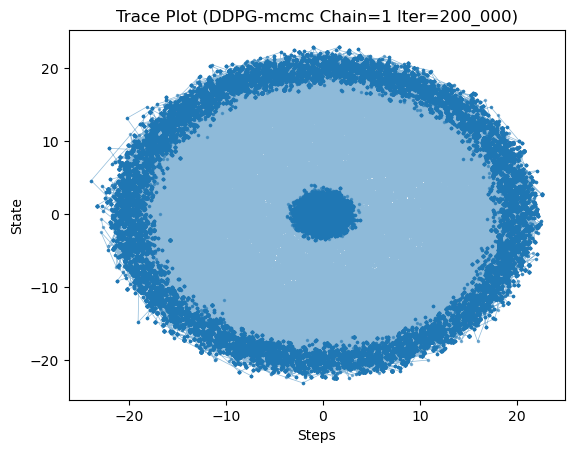

In [10]:
# Trace Plot
plt.plot(state_list[:, 0], state_list[:, 1], 'o-', linewidth=0.5, markersize=1.5, alpha=0.5)
plt.title(f"Trace Plot (DDPG-mcmc Chain=1 Iter=200_000)")
plt.xlabel("Steps")
plt.ylabel("State")
plt.show()

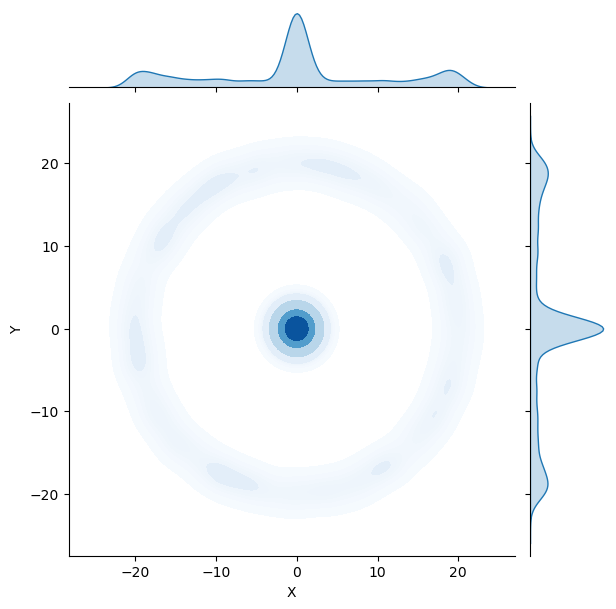

In [11]:
# Marginal Plot
sns.jointplot(x=state_list[:, 0], y=state_list[:, 1], kind='kde', cmap='Blues', fill=True)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

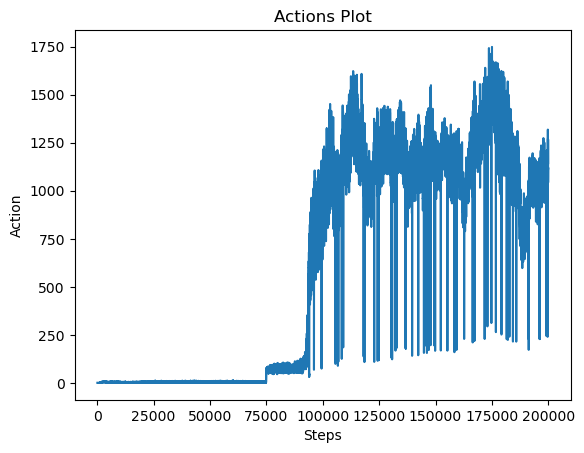

In [12]:
# Action Plot
plt.plot(action_list)
plt.title("Actions Plot")
plt.xlabel("Steps")
plt.ylabel("Action")
plt.show()

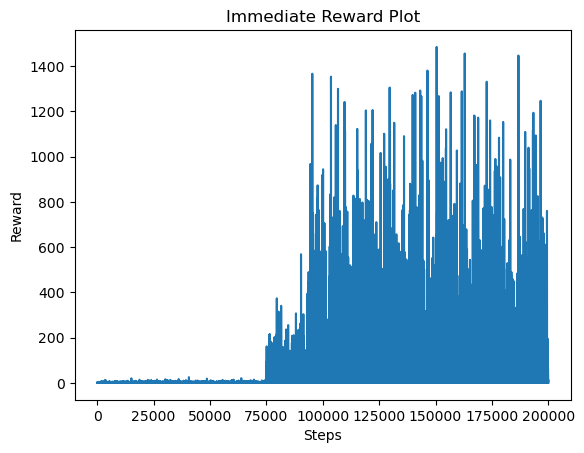

In [13]:
# Immediate Reward Plot
plt.plot(env.store_reward)
plt.title("Immediate Reward Plot")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.show()

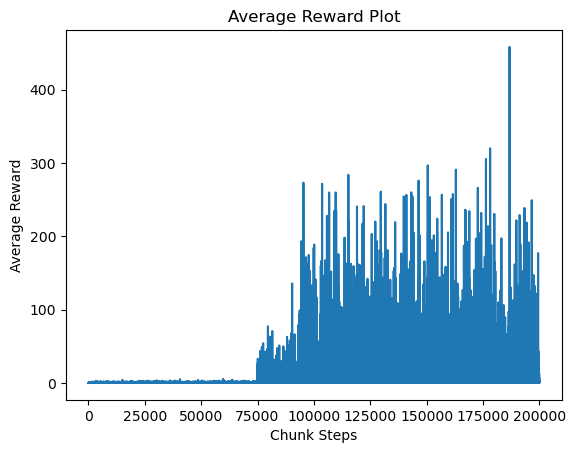

In [14]:
# Average Reward Plot
kernel = np.ones(5) / 5
averages = np.convolve(env.store_reward, kernel, mode='valid')

plt.plot(averages)
plt.title('Average Reward Plot')
plt.xlabel('Chunk Steps')
plt.ylabel('Average Reward')
plt.show()


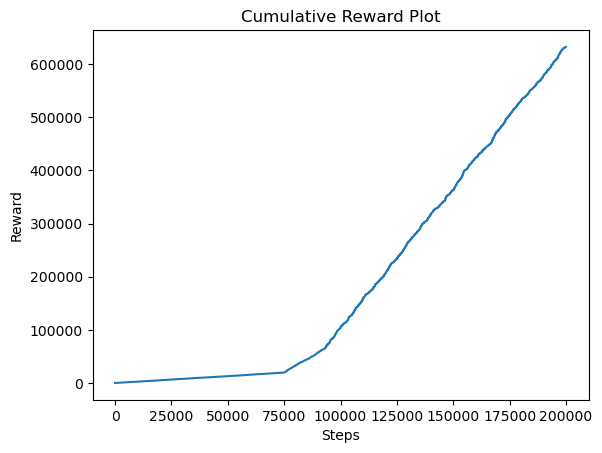

In [15]:
# Cumulative Reward Plot
plt.plot(np.cumsum(env.store_reward))
plt.title("Cumulative Reward Plot")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.show()

In [16]:
# Policy Plot
x = np.linspace(-10, 10, 1000)
y = np.linspace(-10, 10, 1000)
X, Y = np.meshgrid(x, y, indexing='ij')

input_array = jnp.stack([X, Y], axis=-1)
input_array_flat = input_array.reshape(-1, 2)

Z_flat = actor.apply(actor_state.params, input_array_flat)
Z = Z_flat.reshape(1000, 1000)

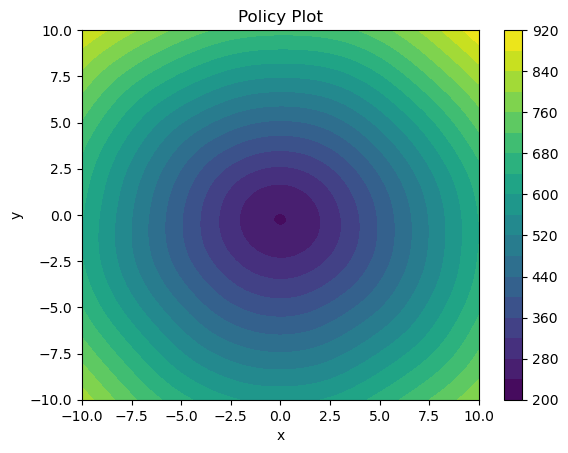

In [17]:
X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, Z.T, 20)
plt.colorbar()

plt.title('Policy Plot')
plt.xlabel('x')
plt.ylabel('y')

plt.show()

In [18]:
# Q Plot
x = np.linspace(-10, 10, 1000)
y = np.linspace(-10, 10, 1000)
a = np.linspace(0, 10, 1000)

X, A_x = np.meshgrid(x, a, indexing='ij')
Y, A_y = np.meshgrid(y, a, indexing='ij')

X_jax = jnp.array(X).reshape(-1, 1)
Y_jax = jnp.array(Y).reshape(-1, 1)
A_x_jax = jnp.array(A_x).reshape(-1, 1)
A_y_jax = jnp.array(A_y).reshape(-1, 1)

input_x = jnp.hstack([X_jax, jnp.zeros_like(X_jax)])
input_y = jnp.hstack([jnp.zeros_like(Y_jax), Y_jax])

Z_x_flat = qf1.apply(qf1_state.params, input_x, A_x_jax)
Z_y_flat = qf1.apply(qf1_state.params, input_y, A_y_jax)

Z_x = Z_x_flat.reshape(1000, 1000)
Z_y = Z_y_flat.reshape(1000, 1000)

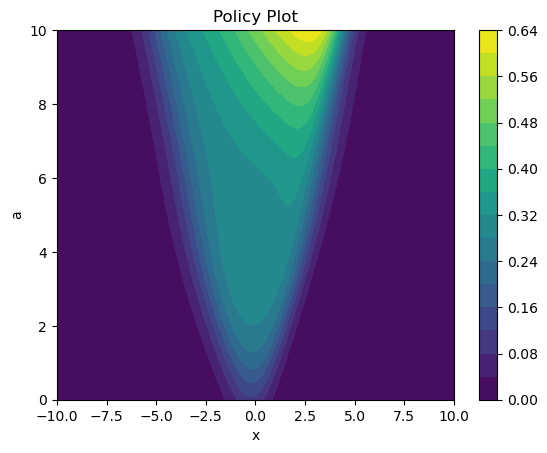

In [19]:
X, A = np.meshgrid(x, a)
plt.contourf(X, A, Z_x.T, 20)
plt.colorbar()

plt.title('Policy Plot')
plt.xlabel('x')
plt.ylabel('a')

plt.show()

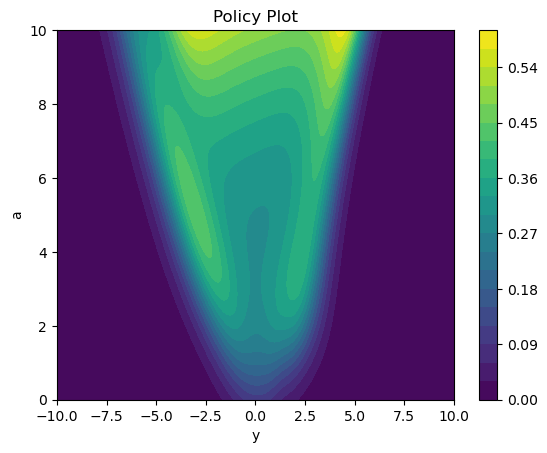

In [20]:
Y, A = np.meshgrid(y, a)
plt.contourf(Y, A, Z_y.T, 20)
plt.colorbar()

plt.title('Policy Plot')
plt.xlabel('y')
plt.ylabel('a')

plt.show()

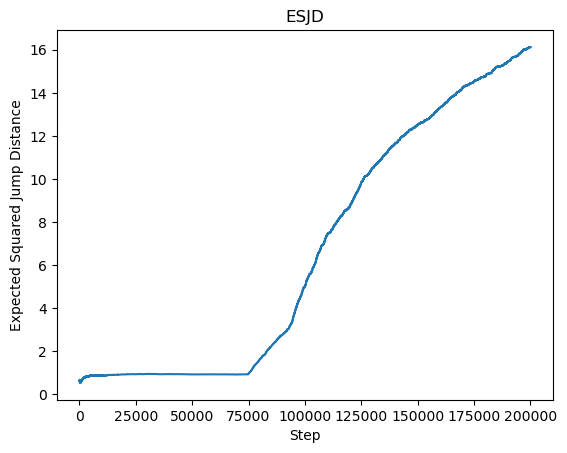

In [21]:
# ESJD Plot (Monte Carlo)
differences = np.diff(state_list, axis=0)
squared_jump_distances = np.sum(differences**2, axis=1)
cumulative_avg_squared_jump_distances = np.cumsum(squared_jump_distances) / (np.arange(args.total_timesteps) + 1)

plt.plot(range(args.total_timesteps)[100:], cumulative_avg_squared_jump_distances[100:])
plt.xlabel('Step')
plt.ylabel('Expected Squared Jump Distance')
plt.title('ESJD')
plt.show()